# COVID-19 Deaths Per Capita
> Comparing death rates adjusting for population size. 

- comments: true
- author: Joao B. Duarte
- categories: [growth, compare]
- hide: false
- image: images/covid-permillion-trajectories.png
- permalink: /covid-compare-permillion/

In [1]:
#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
chart_size = (11,6)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Deaths Per Million Of Habitants

Since reaching at least 1 death per million

In [2]:
#hide 
data = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv", error_bad_lines=False)
data = data.drop(columns=["Lat", "Long"])
data = data.melt(id_vars= ["Province/State", "Country/Region"])
data = pd.DataFrame(data.groupby(['Country/Region', "variable"]).sum())
data.reset_index(inplace=True)  
data = data.rename(columns={"Country/Region": "location", "variable": "date", "value": "total_cases"})
data['date'] =pd.to_datetime(data.date)
data = data.sort_values(by = "date")
data.loc[data.location == "US","location"] = "United States"
data.loc[data.location == "Korea, South","location"] = "South Korea"

data_pwt = pd.read_stata("https://www.rug.nl/ggdc/docs/pwt91.dta")

filter1 = data_pwt["year"] == 2017
data_pop = data_pwt[filter1]
data_pop = data_pop[["country","pop"]]
data_pop.loc[data_pop.country == "Republic of Korea","country"] = "South Korea"
data_pop.loc[data_pop.country == "Iran (Islamic Republic of)","country"] = "Iran"

# per habitant
data_pc = data.copy()
countries = ["China", "Italy", "Spain", "France", "United Kingdom", "Germany", 
             "Portugal", "United States", "Singapore","South Korea", "Japan", 
             "Brazil","Iran"]
data_countries = []
data_countries_pc = []

# compute per habitant
for i in countries:
    data_pc.loc[data_pc.location == i,"total_cases"] = data_pc.loc[data_pc.location == i,"total_cases"]/float(data_pop.loc[data_pop.country == i, "pop"])

    # get each country time series
filter1 = data_pc["total_cases"] > 1
for i in countries:
    filter_country = data_pc["location"]== i
    data_countries_pc.append(data_pc[filter_country & filter1])

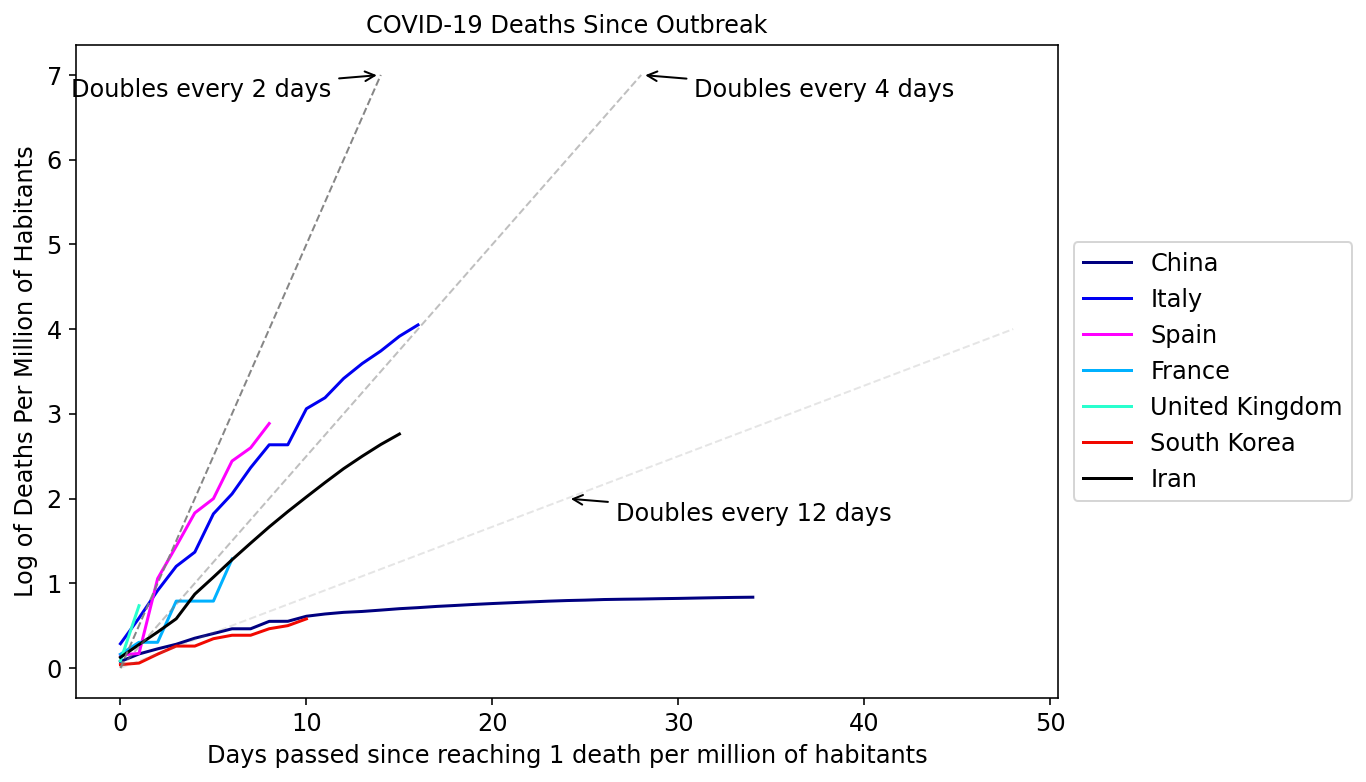

In [3]:
#hide_input
# Plot it

n = 11
colors = plt.cm.jet(np.linspace(0,1,n))
colors = np.concatenate((colors, np.array([0,0,0,1]).reshape(1,4)), axis = 0)
colors = np.concatenate((colors, np.array([0,0,0,1]).reshape(1,4)), axis = 0)
colors[6] = np.array([0.80645161, 0.1   , 0.16129032, 1.        ])
colors[-2] = np.array([0, 0.5, 0, 1       ])
colors[2] = np.array([1, 0, 1, 1       ])

fig, ax = plt.subplots( figsize = chart_size)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8,  box.height])
for i, name in enumerate(countries):
    if len(data_countries_pc[i]) == 0: continue
    ax.plot(np.arange(0,len(data_countries_pc[i])),np.log(data_countries_pc[i]["total_cases"]),label = name, color = colors[i])
ax.plot(np.arange(0,8)*2, np.arange(0,8), 
        alpha = 0.95, linestyle = "--", color = "grey", linewidth = 1)
ax.plot(np.arange(0,8)*4, np.arange(0,8), 
        alpha = 0.5, linestyle = "--", color = "grey", linewidth = 1)
ax.plot(np.arange(0,5)*12, np.arange(0,5), 
        alpha = 0.2, linestyle = "--", color = "grey", linewidth = 1)
a = np.arange(0,3)*12
b = np.arange(0,3)
ax.annotate('Doubles every 12 days', xy=(a[-1], b[-1]),  xycoords='data',
            xytext=(0.55, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',  arrowstyle="->"),
            horizontalalignment='left', verticalalignment='top',
            )
a = np.arange(0,8)*4
b = np.arange(0,8)
ax.annotate('Doubles every 4 days', xy=(a[-1], b[-1]),  xycoords='data',
            xytext=(0.63, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',  arrowstyle="->"),
            horizontalalignment='left', verticalalignment='top',
            )
a = np.arange(0,8)*2
b = np.arange(0,8)
ax.annotate('Doubles every 2 days',  xy=(a[-1], b[-1]),  xycoords='data',
            xytext=(0.26, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',  arrowstyle="->"),
            horizontalalignment='right', verticalalignment='top',
            )
plt.legend(loc='right', bbox_to_anchor= (1.3, 0.5), ncol=1, 
            borderaxespad=0, frameon=True)
plt.ylabel(r"Log of Deaths Per Million of Habitants",
           usetex=False, size = 12)
plt.xlabel(r"Days passed since reaching 1 death per million of habitants", 
           usetex=False, size = 12)
plt.title(r"COVID-19 Deaths Since Outbreak",  usetex=False)
plt.show()

In [4]:
#hide
fig.savefig('../images/covid-permillion-trajectories.png')

Last Available Total Deaths By Country:

In [5]:
#hide_input
label = 'Deaths'
temp = pd.concat([x.copy() for x in data_countries_pc]).loc[lambda x: x.date >= '3/1/2020']

metric_name = f'{label} per Million'
temp.columns = ['Country', 'date', metric_name]
# temp.loc[:, 'month'] = temp.date.dt.strftime('%Y-%m')
temp.loc[:, f'Log of {label} per Million'] = temp[f'{label} per Million'].apply(lambda x: np.log10(x))

temp.groupby('Country').last()

# summary = temp.set_index('date').groupby(['Country', 'month']).last()
# pd.pivot_table(summary, 
#                index='Country', 
#                values=[f'Log of Total {label} per Million',metric_name], 
#                columns='month').fillna('')

,date,Deaths per Million,Log of Deaths per Million
Country,,,
China,2020-03-19,2.305044,0.362679
France,2020-03-19,3.614654,0.558067
Iran,2020-03-19,15.820058,1.199208
Italy,2020-03-19,57.361955,1.758624
South Korea,2020-03-19,1.784936,0.251623
Spain,2020-03-19,17.905559,1.252988
United Kingdom,2020-03-19,2.085172,0.319142


In [6]:
#hide
# Get data and clean it

data = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv", error_bad_lines=False)
data = data.drop(columns=["Lat", "Long"])
data = data.melt(id_vars= ["Province/State", "Country/Region"])
data = pd.DataFrame(data.groupby(['Country/Region', "variable"]).sum())
data.reset_index(inplace=True)  
data = data.rename(columns={"Country/Region": "location", "variable": "date", "value": "total_cases"})
data['date'] =pd.to_datetime(data.date)
data = data.sort_values(by = "date")
data.loc[data.location == "US","location"] = "United States"
data.loc[data.location == "Korea, South","location"] = "South Korea"

# Population data (last year is 2017 which is what we use)
data_pwt = pd.read_stata("https://www.rug.nl/ggdc/docs/pwt91.dta")

filter1 = data_pwt["year"] == 2017
data_pop = data_pwt[filter1]
data_pop = data_pop[["country","pop"]]
data_pop.loc[data_pop.country == "Republic of Korea","country"] = "South Korea"
data_pop.loc[data_pop.country == "Iran (Islamic Republic of)","country"] = "Iran"

# per habitant
data_pc = data.copy()

# I can add more countries if needed
countries = ["China", "Italy", "Spain", "France", "United Kingdom", "Germany", 
             "Portugal", "United States", "Singapore","South Korea", "Japan", 
             "Brazil","Iran"]

data_countries = []
data_countries_pc = []

# compute per habitant
for i in countries:
    data_pc.loc[data_pc.location == i,"total_cases"] = data_pc.loc[data_pc.location == i,"total_cases"]/float(data_pop.loc[data_pop.country == i, "pop"])
    
# get each country time series
filter1 = data_pc["total_cases"] > 1

for i in countries:
    filter_country = data_pc["location"]== i
    data_countries_pc.append(data_pc[filter_country & filter1])

## Appendix

> Warning: The following chart, "Cases Per Million of Habitants" is biased depending on how widely a country administers tests.  Please read with caution.  

### Cases Per Million of Habitants

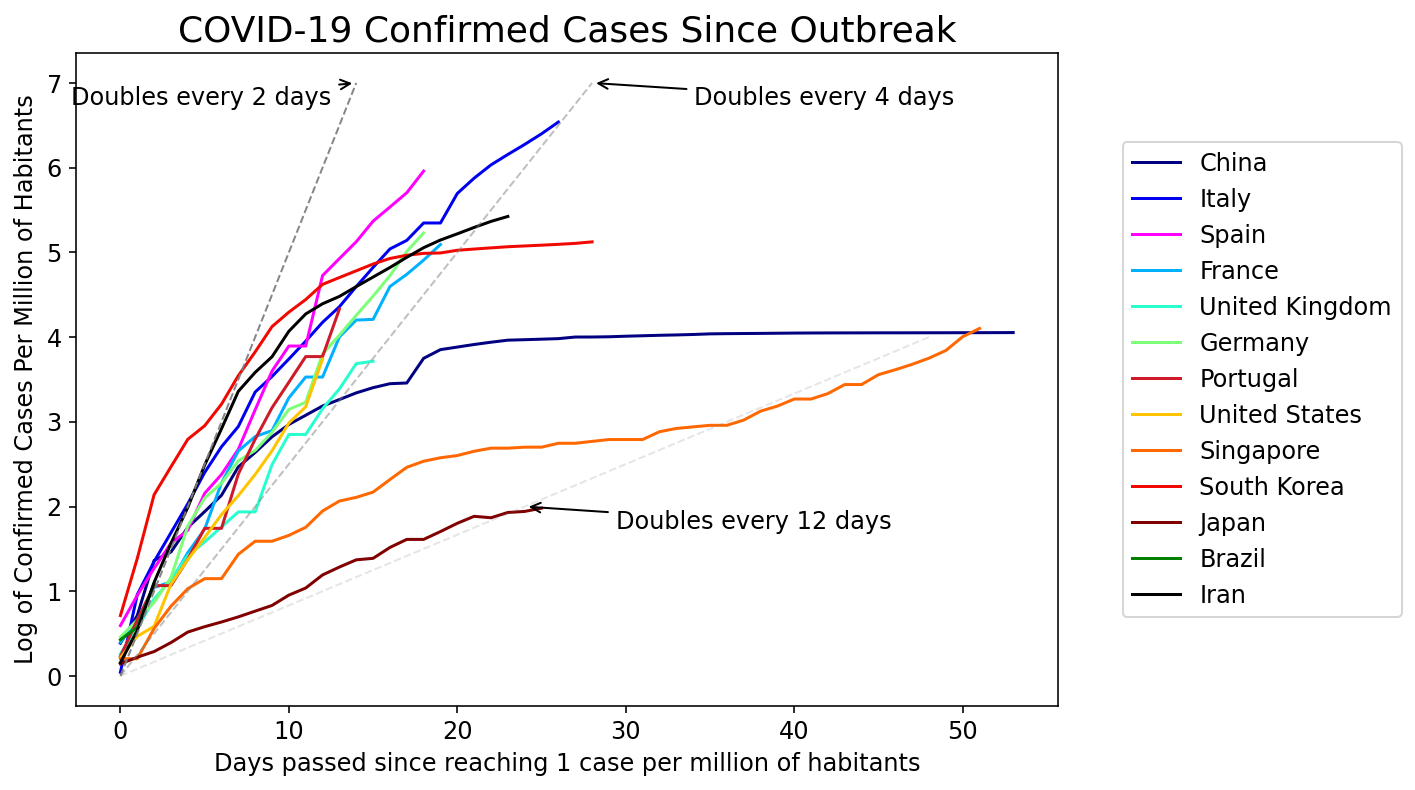

In [7]:
#hide_input
# Plot it
n = 11
colors = plt.cm.jet(np.linspace(0,1,n))
colors = np.concatenate((colors, np.array([0,0,0,1]).reshape(1,4)), axis = 0)
colors = np.concatenate((colors, np.array([0,0,0,1]).reshape(1,4)), axis = 0)
colors[6] = np.array([0.80645161, 0.1   , 0.16129032, 1.        ])
colors[-2] = np.array([0, 0.5, 0, 1       ])
colors[2] = np.array([1, 0, 1, 1       ])

types = ['-']*13

fig, ax = plt.subplots( figsize = chart_size)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8,  box.height])
for i, name in enumerate(countries):
    ax.plot(np.arange(0,len(data_countries_pc[i])),np.log(data_countries_pc[i]["total_cases"]),
            label = name, color = colors[i], linestyle = types[i])
ax.plot(np.arange(0,8)*2, np.arange(0,8), 
        alpha = 0.95, linestyle = "--", color = "grey", linewidth = 1)
ax.plot(np.arange(0,8)*4, np.arange(0,8), 
        alpha = 0.5, linestyle = "--", color = "grey", linewidth = 1)
ax.plot(np.arange(0,5)*12, np.arange(0,5), 
        alpha = 0.2, linestyle = "--", color = "grey", linewidth = 1)
a = np.arange(0,3)*12
b = np.arange(0,3)
ax.annotate('Doubles every 12 days', xy=(a[-1], b[-1]),  xycoords='data',
            xytext=(0.55, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',  arrowstyle="->"),
            horizontalalignment='left', verticalalignment='top',
            )
a = np.arange(0,8)*4
b = np.arange(0,8)
ax.annotate('Doubles every 4 days', xy=(a[-1], b[-1]),  xycoords='data',
            xytext=(0.63, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',  arrowstyle="->"),
            horizontalalignment='left', verticalalignment='top',
            )
a = np.arange(0,8)*2
b = np.arange(0,8)
ax.annotate('Doubles every 2 days',  xy=(a[-1], b[-1]),  xycoords='data',
            xytext=(0.26, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',  arrowstyle="->"),
            horizontalalignment='right', verticalalignment='top',
            )
plt.legend(loc='right', bbox_to_anchor= (1.35, 0.5), ncol=1, 
            borderaxespad=0, frameon=True)
plt.ylabel(r"Log of Confirmed Cases Per Million of Habitants", 
           usetex=False, size = 12)
plt.xlabel(r"Days passed since reaching 1 case per million of habitants", 
           usetex=False, size = 12)
plt.title(r"COVID-19 Confirmed Cases Since Outbreak",  
          usetex=False, fontsize=BIGGER_SIZE)
plt.show()

Last Available Count on Confirmed Cases By Country

In [8]:
#hide_input
label = 'Cases'
temp = pd.concat([x.copy() for x in data_countries_pc]).loc[lambda x: x.date >= '3/1/2020']

metric_name = f'{label} per Million'
temp.columns = ['Country', 'date', metric_name]
# temp.loc[:, 'month'] = temp.date.dt.strftime('%Y-%m')
temp.loc[:, f'Log of {label} per Million'] = temp[f'{label} per Million'].apply(lambda x: np.log10(x))


# summary = temp.set_index('date').groupby(['Country', 'month']).last()
# pd.pivot_table(summary, 
#                index='Country', 
#                values=[f'Log of Total {label} per Million',metric_name], 
#                columns='month').fillna('')

temp.groupby('Country').last()

,date,Cases per Million,Log of Cases per Million
Country,,,
Brazil,2020-03-19,2.967199,0.472347
China,2020-03-19,57.577151,1.760250
France,2020-03-19,162.837938,2.211756
Germany,2020-03-19,186.569374,2.270840
Iran,2020-03-19,226.791124,2.355626
Italy,2020-03-19,691.291579,2.839661
Japan,2020-03-19,7.247943,0.860215
Portugal,2020-03-19,75.995890,1.880790
Singapore,2020-03-19,60.432548,1.781271


This analysis was conducted by [Joao B. Duarte](https://www.jbduarte.com).  Relevant sources are listed below: [^1][^2]

[^1]: ["2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19). 

[^2]: [Feenstra, Robert C., Robert Inklaar and Marcel P. Timmer (2015), "The Next Generation of the Penn World Table" American Economic Review, 105(10), 3150-3182](https://www.rug.nl/ggdc/productivity/pwt/related-research)